In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.lines import Line2D
from scipy.stats import ttest_rel, wilcoxon

In [2]:
plt.rcParams.update({'font.size': 16})
pd.set_option("display.max_columns", None)

In [3]:
def add_label_to_df(df, path_to_labels):
    """Add label description to the input dataframe."""
    if Path(path_to_labels).is_dir():
        series_to_labels_mapping = {}
        for path in Path(path_to_labels).glob('*.json'):
            with open(path, 'r') as file:
                labels = json.load(file)
                series_to_labels_mapping.update({
                    f"{path.stem}": labels
                })
    elif Path(path_to_labels).is_file():
        with open(path_to_labels, 'r') as file:
            series_to_labels_mapping = json.load(file)
    else:
        raise ValueError(f"path_to_labels ''{path_to_labels}' must be file or directory'")
    labels_mapping_list = [
        {
            "series_uuid": series,
            "foreground_label": int(value),
            "label_description": ','.join([value_.lower().strip() for value_ in label.split(',')])
        }
        for series, mapping in series_to_labels_mapping.items()
        for value, label in mapping.items()
    ]
    labels_mapping_df = pd.DataFrame(labels_mapping_list)
    new_df = df.copy()
    new_df["series_uuid"] = new_df["ct_fname"].apply(lambda x: x.split('.nii.gz')[0])
    merged_df = new_df.merge(labels_mapping_df, on=["series_uuid", "foreground_label"], how='left')
    return merged_df

In [4]:
def add_patient_info_to_df(df, path_to_patients, path_to_series):
    """Add patient information to each row of the input dataframe.

    Parameters
    ----------
    df : pd dataframe
        Input dataframe containing performance for each bounding box.
    path_to_patients : str
        Path to the 'patients.csv' file containing patient id columns
        'id_proyecto', 'code', 'sexo', 'edad', 'diagnóstico'.
    path_to_series : str
        Path to the 'series.json' containing series metadata.
    """
    patient_columns = [
        'patient_id',
        'patient_code',
        'sex',
        'age',
        'diagnosis'
    ]
    patients_df = pd.read_csv(path_to_patients)
    with open(path_to_series, 'r') as file:
        series_df = pd.DataFrame(json.load(file))
    series_df['patient_code'] = series_df['patient_code'].astype('int64')
    series_df = pd.merge(
        series_df,
        patients_df[patient_columns],
        left_on=['patient_code', 'patient_id'],
        right_on=['patient_code', 'patient_id'],
        how='inner'       
    )
    output_df = pd.merge(
        df,
        series_df[patient_columns + ['uuid']],
        left_on='study',
        right_on='uuid',
        how='inner'
    )
    output_df.drop(columns=['uuid'], inplace=True)
    return output_df

In [5]:
def concatenate_iteration_dfs(iteration_dfs, keep_only_common_between_iterations=True):
    """Return concatenated dataframes with the column 'iteration'
    added.

    Parameters
    ----------
    iteration_dfs : list
        Each item is a dictionary with the following keys:
            'path': path to the performance JSON file.
            'iteration': integer indicating the iteration.
    keep_only_common_between_iterations : bool, optional
        Remove rows with bounding boxes that are absent in at least one iteration.
        The resulting dataframe has rows with bounding boxes present in all iterations.
    """
    dfs = []
    for item in iteration_dfs:
        with open(item['path'], 'r') as file:
            df = pd.DataFrame(json.load(file)['bboxes'])
        df['iteration'] = item['iteration']
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True).sort_values(by='iteration')
    if keep_only_common_between_iterations:
        common_bboxes = set(concatenated_df['bbox_original_fname'])
        for iteration in concatenated_df['iteration'].unique():
            common_bboxes = common_bboxes.intersection(set(concatenated_df[concatenated_df['iteration'] == iteration]['bbox_original_fname']))
        concatenated_df = concatenated_df[concatenated_df['bbox_original_fname'].isin(common_bboxes)]
    return concatenated_df

In [6]:
def run_paired_test(performance_df, iteration_a = 0, iteration_b = 1, test='wilcoxon', alternative='greater'):
    "Test the difference between the means of both iterations (iteration_b - iteration_a)."
    performance_df_subset = performance_df[(performance_df['iteration'] == iteration_a) | (performance_df['iteration'] == iteration_b)].copy()
    duplicated = performance_df_subset['bbox_original_fname'].duplicated(keep=False)
    filtered = performance_df_subset[duplicated]
    filtered_a = filtered[filtered['iteration'] == iteration_a].copy()
    filtered_b = filtered[filtered['iteration'] == iteration_b].copy()
    filtered_a.sort_values(by='bbox_original_fname', inplace=True)
    filtered_b.sort_values(by='bbox_original_fname', inplace=True)
    new_df = {
        f"index_iteration_{iteration_a}": filtered_a.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_a}": filtered_a['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_a}": filtered_a['dice_score'].to_list(),
        f"index_iteration_{iteration_b}": filtered_b.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_b}": filtered_b['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_b}": filtered_b['dice_score'].to_list()
    }
    new_df = pd.DataFrame(new_df)
    new_df['paired_sample'] = new_df.apply(
        lambda row: row[f"bbox_original_fname_iteration_{iteration_a}"] == row[f"bbox_original_fname_iteration_{iteration_b}"],
        axis=1
    )
    new_df['difference'] = new_df[f"dice_score_iteration_{iteration_a}"] - new_df[f"dice_score_iteration_{iteration_b}"]
    if test == 'ttest':
        test_result = ttest_rel(
            new_df[f"dice_score_iteration_{iteration_b}"],
            new_df[f"dice_score_iteration_{iteration_a}"],
            alternative=alternative
        )
        stat = test_result.statistic
        p_value = test_result.pvalue
    elif test == 'wilcoxon':
        stat, p_value = wilcoxon(
            new_df[f"dice_score_iteration_{iteration_b}"],
            new_df[f"dice_score_iteration_{iteration_a}"],
            alternative=alternative
        )
    return stat, p_value, new_df

In [7]:
# Input parameters
iteration_dfs = [
    {
        'path': Path.cwd() / "resources" / "hitl-performance" / "final" / "test-evaluation" / "iteration-0" / "performance.json",
        'iteration': 0
    },
    {
        'path': Path.cwd() / "resources" / "hitl-performance" / "final" / "test-evaluation" / "iteration-1" / "performance_cv_iteration_1_MedSAM-ViT-B-20240423-1349.json",
        'iteration': 1
    },
    {
        'path': Path.cwd() / "resources" / "hitl-performance" / "final" / "test-evaluation" / "iteration-2" /"performance_cv_iteration_2_MedSAM-ViT-B-20240730-1505.json",
        'iteration': 2
    },
    {
        'path': Path.cwd() / "resources" / "hitl-performance" / "final" / "test-evaluation" / "iteration-3" /"performance_cv_iteration_10_MedSAM-ViT-B-20241230-0430.json",
        'iteration': 3
    }
]
min_size_pixels = 10
savefig = True
savecsv = True
dpi = 600
path_to_labels = Path.cwd() / "resources" / "hitl-performance" / "final" / "labels-test"
path_to_patients = Path.cwd() / ".." / "data" / "final" / "metadata" / "patients.csv"
path_to_series = Path.cwd() / ".." / "data" / "final" / "metadata" / "series.json"
performance_df = concatenate_iteration_dfs(iteration_dfs)
performance_df = add_label_to_df(performance_df, path_to_labels)
performance_df = add_patient_info_to_df(performance_df, path_to_patients, path_to_series)
performance_df = performance_df[performance_df['annotated_pixels'] >= min_size_pixels]

In [8]:
# 2D objects for each patient
grouped = performance_df[performance_df['iteration'] == 0].groupby(['patient_id', 'patient_code', 'diagnosis']).size().reset_index(name='2d_objects_count')
display(grouped)

,patient_id,patient_code,diagnosis,2d_objects_count
0,3,3,gallbladder cancer,344
1,10,10,melanoma,18
2,13,13,gastric cancer,175
3,15,15,bladder cancer,115
4,18,18,colon cancer,116
5,28,28,colon cancer,3904
6,30,30,rectal cancer,474
7,35,35,gastric cancer,102


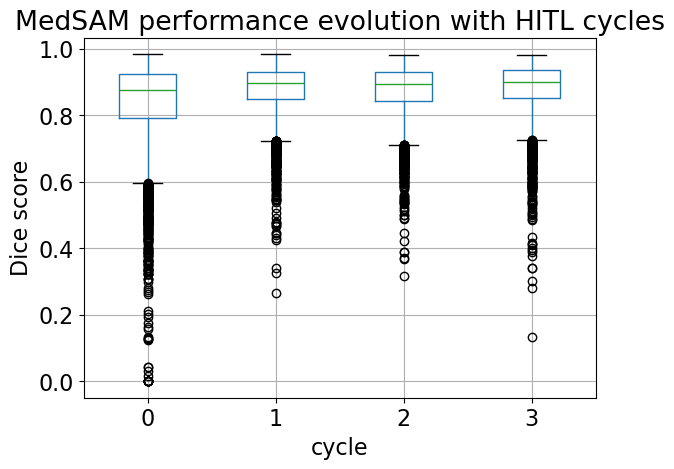

dice_score                                                    \
               count      mean       std       min        5%       25%   
iteration                                                                
0             5248.0  0.837266  0.129038  0.000000  0.576741  0.792793   
1             5248.0  0.878694  0.074704  0.264151  0.736564  0.847628   
2             5248.0  0.875660  0.075484  0.315789  0.733333  0.842105   
3             5248.0  0.881934  0.077402  0.133333  0.738523  0.850865   

                                                   
                50%       75%       95%       max  
iteration                                          
0          0.876835  0.924092  0.957017  0.983519  
1          0.897059  0.930918  0.960875  0.982369  
2          0.892857  0.929577  0.960880  0.980492  
3          0.900474  0.935248  0.963596  0.981668

In [9]:
# Boxplot of Dice score for each iteration (all lesions)
performance_df.boxplot(column='dice_score', by='iteration')
plt.suptitle('')
plt.xlabel('cycle')
plt.ylabel('Dice score')
plt.title('MedSAM performance evolution with HITL cycles')
plt.show()
display(performance_df[['dice_score', 'iteration']].groupby('iteration').describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

In [10]:
iterations = performance_df['iteration'].unique()
iterations_count = len(iterations)
lesion_types_count = len(performance_df['label_description'].unique())
print(f"# iterations: {iterations_count}")
print(f"# lesion types: {lesion_types_count}")

# iterations: 4
# lesion types: 9


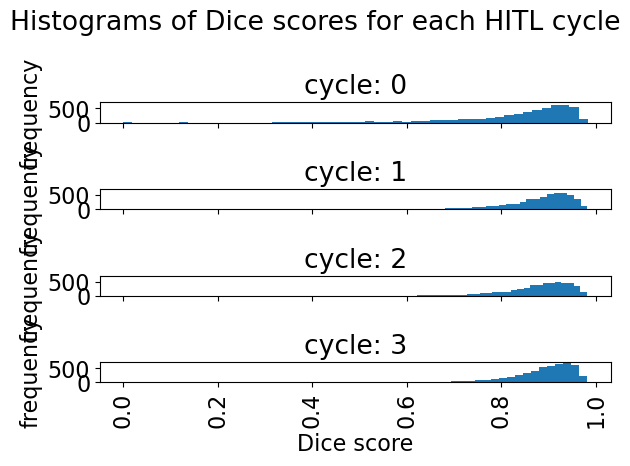

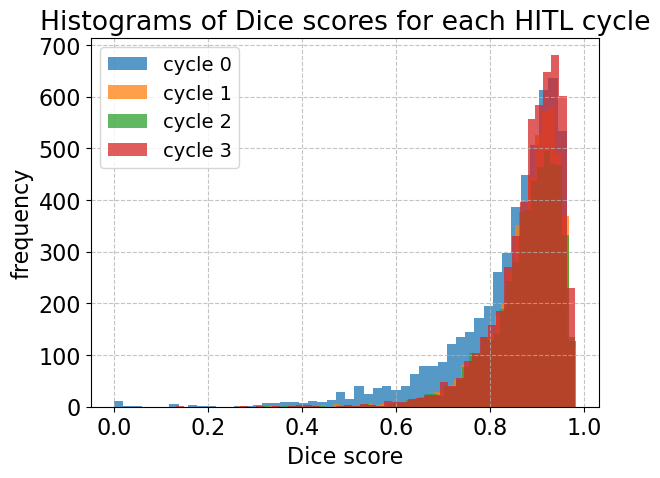

In [11]:
# Histogram of Dice score for each iteration (all lesions)
fig, ax = plt.subplots(nrows=iterations_count, ncols=1, sharex=True, sharey=True)
performance_df.hist(
    column='dice_score',
    by='iteration',
    bins=50,
    ax=ax
)
fig.suptitle('Histograms of Dice scores for each HITL cycle')
for idx in range(iterations_count):
    ax[idx].set_ylabel('frequency')
    ax[idx].set_title(f"cycle: {iterations[idx]}")
ax[-1].set_xlabel('Dice score')
plt.tight_layout()
plt.show()
# Overlapped histograms
fig, ax = plt.subplots(nrows=1, ncols=1)
cmap = plt.get_cmap('tab10')
for it in iterations:
    performance_df[performance_df['iteration'] == it].hist(
        column='dice_score',
        bins=50,
        ax=ax,
        color=cmap(it),
        alpha=0.75,
        label=f"cycle {it}"
    )
ax.legend(fontsize=14)
ax.set_title('')
ax.set_xlabel('Dice score')
ax.set_ylabel('frequency')
plt.tight_layout()
plt.grid(linestyle='--', alpha=0.75)
#plt.grid(False)
if savefig:
    plt.savefig(Path.cwd() / 'results' / 'hitl_overlapped_histograms.svg', bbox_inches='tight', transparent=True, dpi=dpi)
ax.set_title('Histograms of Dice scores for each HITL cycle')
plt.show()

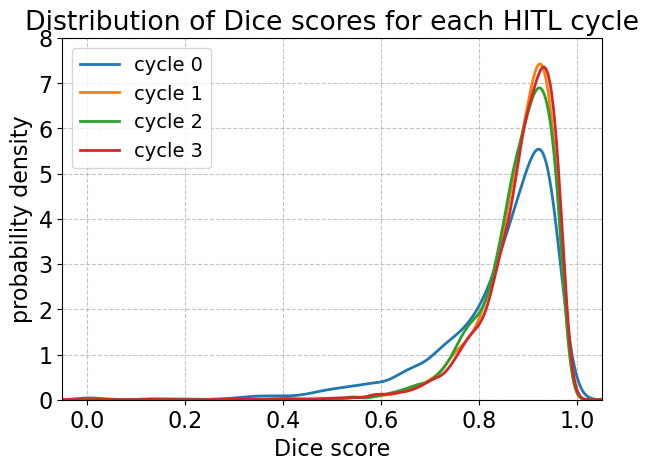

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
cmap = plt.get_cmap('tab10')
for it in iterations:
    performance_df[performance_df['iteration'] == it]["dice_score"].plot.kde(
        ax=ax,
        color=cmap(it),
        linewidth=2,
        label=f"cycle {it}"
    )
    if savefig:
        ax.set_title('')
        ax.set_xlabel('Dice score')
        ax.set_ylabel('probability density')
        ax.legend(fontsize=14, loc='upper left')
        plt.grid(linestyle='--', alpha=0.75)
        plt.xlim((-0.05, 1.05))
        plt.ylim((0, 7))
        plt.savefig(Path.cwd() / 'results' / f'hitl_overlapped_kde_densities_cycle_{it}.svg', bbox_inches='tight', transparent=True, dpi=dpi)
ax.set_title('')
ax.set_xlabel('Dice score')
ax.set_ylabel('probability density')
ax.legend(fontsize=14)
plt.tight_layout()
plt.grid(linestyle='--', alpha=0.75)
plt.xlim((-0.05, 1.05))
plt.ylim((0, 8))
#plt.grid(False)
if savefig:
    plt.savefig(Path.cwd() / 'results' / 'hitl_overlapped_kde_densities.svg', bbox_inches='tight', transparent=True, dpi=dpi)
ax.set_title('Distribution of Dice scores for each HITL cycle')
plt.show()

In [13]:
# Color mapping for label descriptions
unique_lesions = list(performance_df['label_description'].unique())
cmap = plt.get_cmap('tab10')
color_mapping = {
    label: cmap(idx)
    for idx, label in enumerate(unique_lesions)
}
color_mapping["m,lung"], color_mapping["n,pelvis"] = color_mapping["n,pelvis"], color_mapping["m,lung"] 

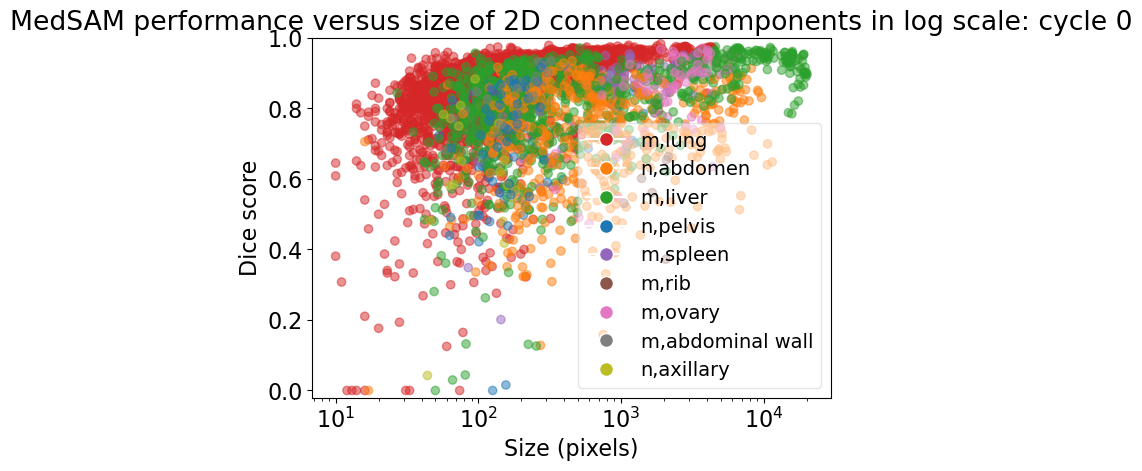

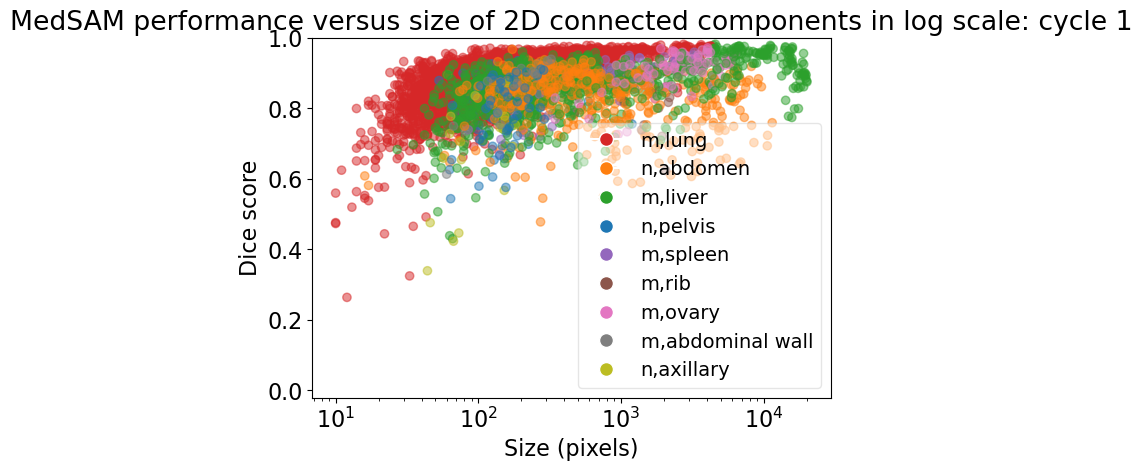

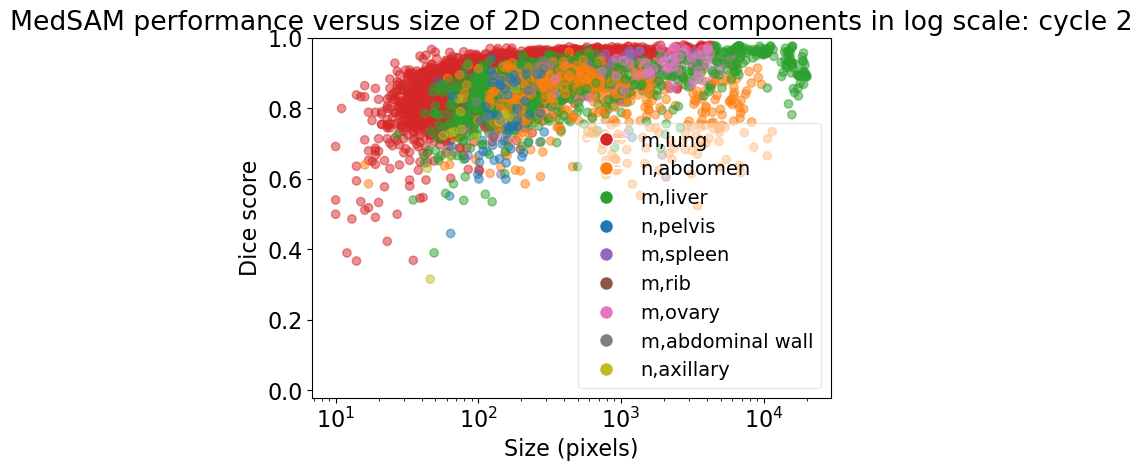

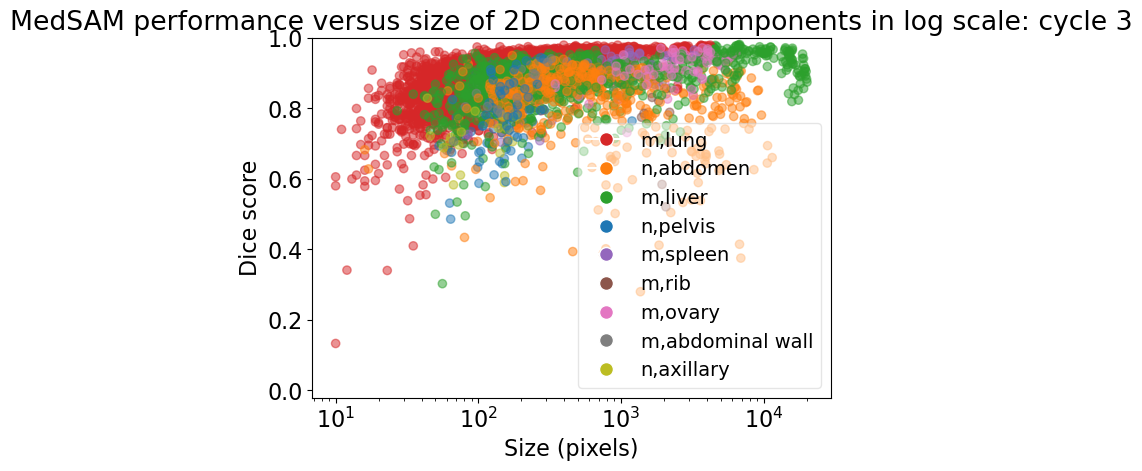

In [14]:
# Scatterplot of Dice versus object size, one plot for each iteration
iterations = list(performance_df['iteration'].unique())
for iteration in iterations:
    _, ax = plt.subplots()
    filtered_df = performance_df[performance_df['iteration'] == iteration]
    colors = filtered_df["label_description"].map(color_mapping)
    ax.scatter(
        filtered_df['annotated_pixels'],
        filtered_df['dice_score'],
        c=colors.to_list(),
        label=filtered_df["label_description"],
        alpha=0.5
    )
    ax.set_xscale('log')
    ax.set_xlabel('Size (pixels)')
    ax.set_ylabel('Dice score')
    # Create legend labels based on unique values in 'label_description' column
    legend_labels = [
        Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_mapping[value], label=value)
        for value in unique_lesions
    ]
    ax.legend(handles=legend_labels, framealpha=0.5, fontsize=14)
    ax.set_ylim([-0.02, 1])
    plt.tight_layout()
    if savefig:
        plt.savefig(
            Path.cwd() / 'results' / f"hitl_medsam_scatterplot_performance_vs_object_size_cycle_{iteration}.svg",
            transparent=True,
            bbox_inches='tight',
            dpi=dpi
        )
    ax.set_title(f'MedSAM performance versus size of 2D connected components in log scale: cycle {iteration}')
    plt.show()

In [15]:
# Color mapping for short-label descriptions
performance_df["short_label_description"] = performance_df['label_description'].apply(lambda x: "adenopathy" if x.split(',')[0] == "n" else x.split(',')[1])
unique_lesions = list(performance_df['short_label_description'].unique())
cmap = plt.get_cmap('tab10')
color_mapping = {
    label: cmap(idx)
    for idx, label in enumerate(unique_lesions)
}
color_mapping["lung"], color_mapping["adenopathy"] = color_mapping["adenopathy"], color_mapping["lung"] 
color_mapping["adenopathy"], color_mapping["ovary"] = color_mapping["ovary"], color_mapping["adenopathy"]

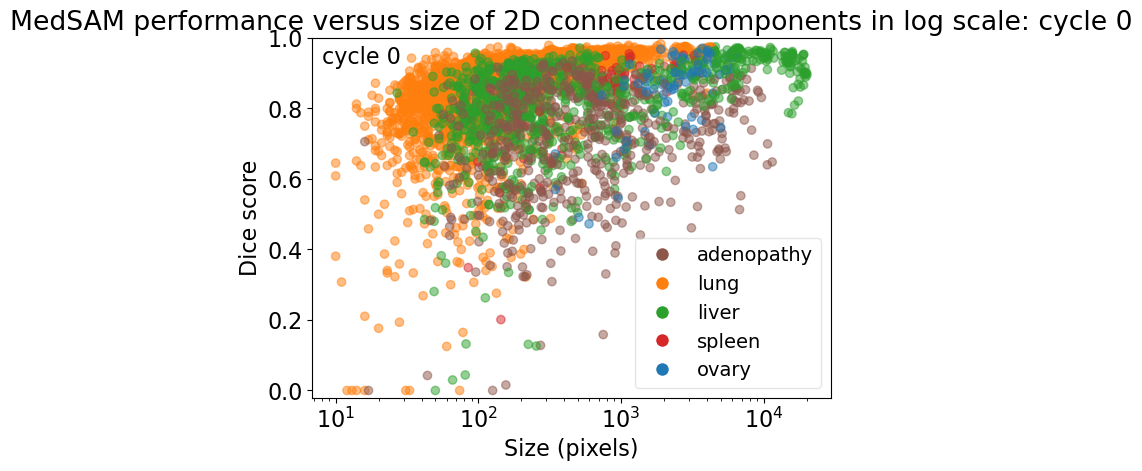

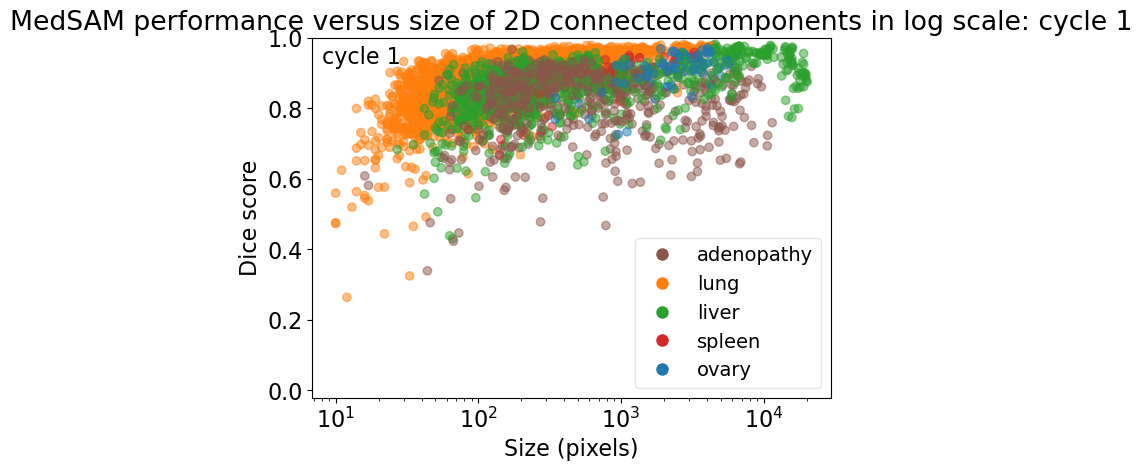

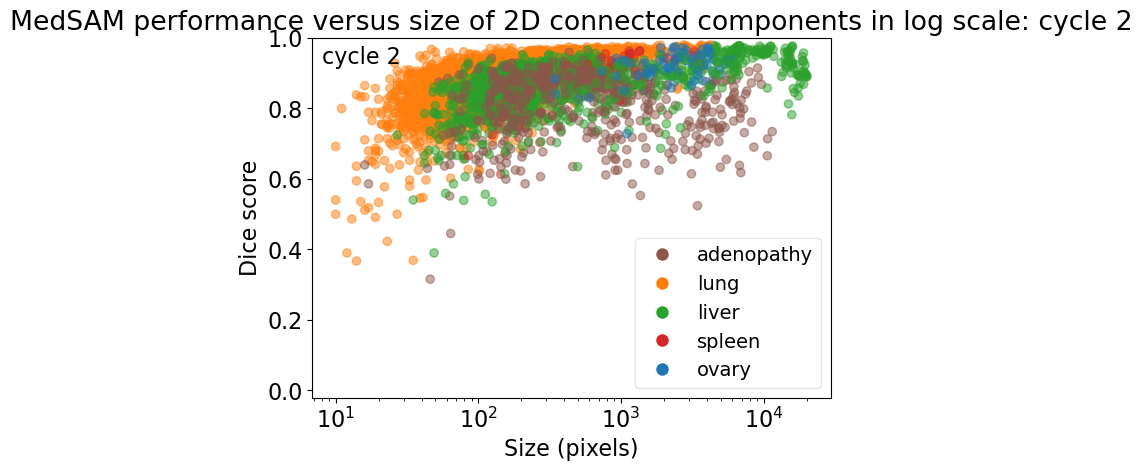

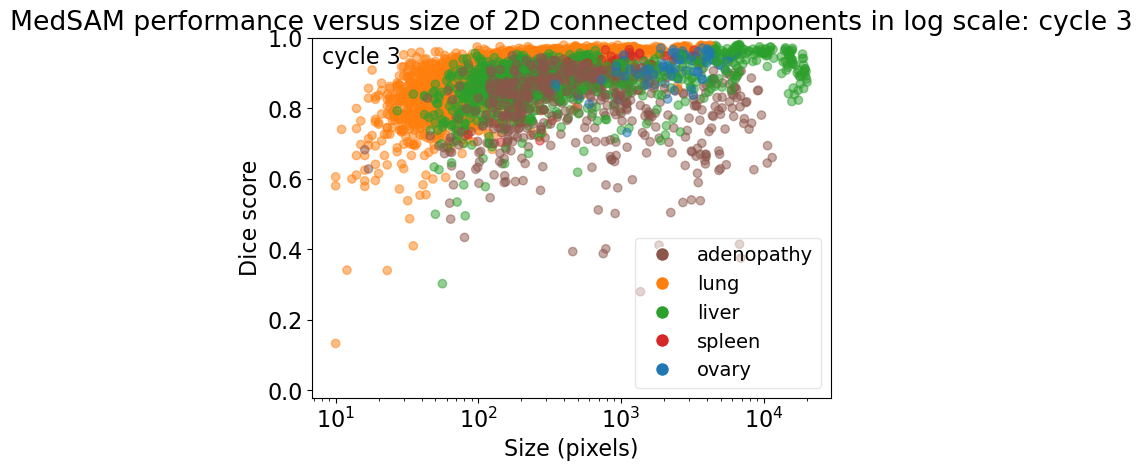

In [16]:
# Scatterplot of Dice versus object size, one plot for each iteration
lesions_subset = ["adenopathy", "lung", "liver", "spleen", "ovary"]
iterations = list(performance_df['iteration'].unique())
for iteration in iterations:
    _, ax = plt.subplots()
    filtered_df = performance_df[
        (performance_df['iteration'] == iteration) &
        (performance_df['short_label_description'].isin(lesions_subset))
    ]
    colors = filtered_df["short_label_description"].map(color_mapping)
    ax.scatter(
        filtered_df['annotated_pixels'],
        filtered_df['dice_score'],
        c=colors.to_list(),
        label=filtered_df["short_label_description"],
        alpha=0.5
    )
    ax.text(
        0.02,
        0.98,
        f"cycle {iteration}",
        fontweight='normal',
        ha='left',
        va='top',
        transform=ax.transAxes
    )
    ax.set_xscale('log')
    ax.set_xlabel('Size (pixels)')
    ax.set_ylabel('Dice score')
    # Create legend labels based on unique values in 'label_description' column
    legend_labels = [
        Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_mapping[value], label=value)
        for value in lesions_subset
    ]
    ax.legend(handles=legend_labels, framealpha=0.5, fontsize=14, loc="lower right")
    ax.set_ylim([-0.02, 1])
    plt.tight_layout()
    if savefig:
        plt.savefig(
            Path.cwd() / 'results' / f"hitl_medsam_scatterplot_performance_vs_object_size_cycle_{iteration}_short_label.svg",
            transparent=True,
            bbox_inches='tight',
            dpi=dpi
        )
    ax.set_title(f'MedSAM performance versus size of 2D connected components in log scale: cycle {iteration}')
    plt.show()

In [17]:
# Hypothesis testing for all dice scores
iteration_a_idx = 0 # before
iteration_b_idx = 3 # after
stat, pvalue, new_df = run_paired_test(
    performance_df,
    iteration_a_idx,
    iteration_b_idx,
    test='wilcoxon',
    alternative='greater'
)
difference = new_df[f'dice_score_iteration_{iteration_b_idx}'] - new_df[f'dice_score_iteration_{iteration_a_idx}']
difference_sample_mean = np.mean(difference)
difference_sample_std = np.std(difference)
print(f"Improvement of Dice scores of cycle {iteration_b_idx} compared to cycle {iteration_a_idx}")
print(70 * '-')
print(f"p value: {pvalue}")
print(f"difference sample median: {np.median(difference)}")
print(f"difference sample IQR: {np.percentile(difference, 25)} - {np.percentile(difference, 75)}")
print(f"difference sample mean: {difference_sample_mean}")
print(f"difference sample std: {difference_sample_std}")

Improvement of Dice scores of cycle 3 compared to cycle 0
----------------------------------------------------------------------
p value: 0.0
difference sample median: 0.01830397076743223
difference sample IQR: 0.00047340003667151187 - 0.05499416834426735
difference sample mean: 0.044668442249277025
difference sample std: 0.09163450422891484


In [18]:
# Hypothesis testing for all dice scores, grouped by lesion
for lesion in performance_df["short_label_description"].unique().tolist():
    stat, pvalue, new_df = run_paired_test(
        performance_df[performance_df["short_label_description"] == lesion],
        iteration_a_idx,
        iteration_b_idx,
        test='wilcoxon',
        alternative='greater'
    )
    difference = new_df[f'dice_score_iteration_{iteration_b_idx}'] - new_df[f'dice_score_iteration_{iteration_a_idx}']
    difference_sample_mean = np.mean(difference)
    difference_sample_std = np.std(difference)
    print(f"Improvement of Dice scores of cycle {iteration_b_idx} compared to cycle {iteration_a_idx}: {lesion}")
    print(70 * '-')
    print(f"p value: {pvalue}")
    print(f"difference sample median: {np.median(difference)}")
    print(f"difference sample IQR: {np.percentile(difference, 25)} - {np.percentile(difference, 75)}")
    print(f"difference sample mean: {difference_sample_mean}")
    print(f"difference sample std: {difference_sample_std}")


Improvement of Dice scores of cycle 3 compared to cycle 0: lung
----------------------------------------------------------------------
p value: 1.467594191385683e-200
difference sample median: 0.013752281273321842
difference sample IQR: -0.00137268351364489 - 0.03850528452439278
difference sample mean: 0.03200432204084265
difference sample std: 0.08004547802959056
Improvement of Dice scores of cycle 3 compared to cycle 0: adenopathy
----------------------------------------------------------------------
p value: 9.611587110251745e-71
difference sample median: 0.06013656698846248
difference sample IQR: 0.013846333536641997 - 0.15093382646628084
difference sample mean: 0.09143888624591627
difference sample std: 0.12215737926751916
Improvement of Dice scores of cycle 3 compared to cycle 0: liver
----------------------------------------------------------------------
p value: 2.1180699534489074e-85
difference sample median: 0.024542813758500093
difference sample IQR: 0.002698607181611301 - 0

In [19]:
# Get the dataframe with the performance difference between iterations
iterations = [0, 3]
pivot_df = performance_df[performance_df['iteration'].isin(iterations)].pivot(
    index=['bbox_original_fname', 'label_description', 'short_label_description', 'annotated_pixels'],
    columns='iteration',
    values='dice_score'
)
first_it_name = f"dice_iteration_{iterations[0]}"
second_it_name = f"dice_iteration_{iterations[1]}"
pivot_df.rename(
    columns={
        iterations[0]: first_it_name,
        iterations[1]: second_it_name
    },
    inplace=True
)
pivot_df['dice_difference'] = pivot_df[second_it_name] - pivot_df[first_it_name]
pivot_df.reset_index(inplace=True)
if savecsv:
    pivot_df.to_csv(Path.cwd() / 'results' / f'hitl_medsam_performance_difference_cycle_{iterations[1]}_vs_cycle_{iterations[0]}.csv', index=False)

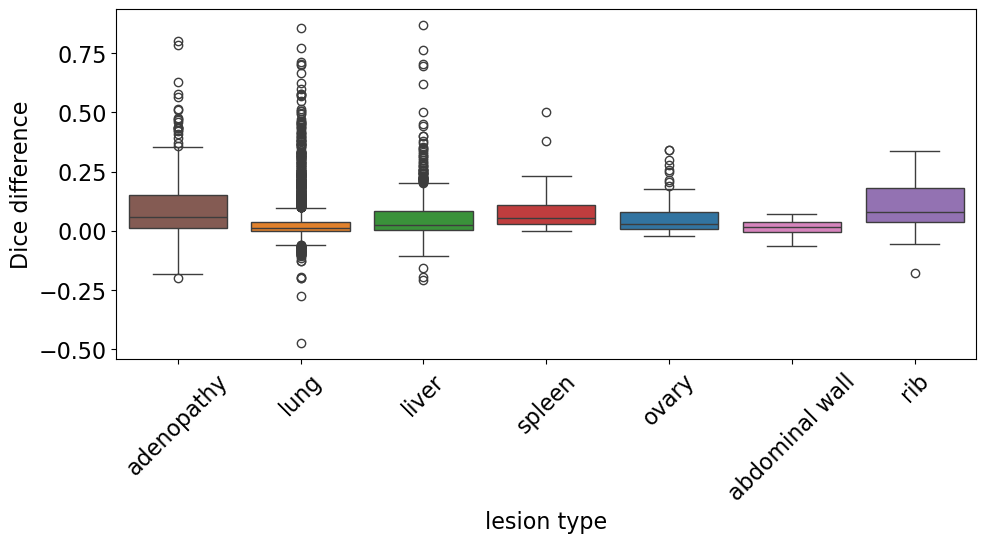

In [20]:
# Boxplot of Dice differences between iterations, grouped by lesion
num_categories = pivot_df["short_label_description"].nunique()
_, ax = plt.subplots(figsize=(max(10, num_categories * 0.5), 6)) 
sns.boxplot(
    data=pivot_df,
    x='short_label_description',
    y='dice_difference',
    palette=color_mapping,
    hue='short_label_description',
    legend=False
)
plt.title(f'Boxplot of Dice differences between cycle {iterations[1]} and {iterations[0]}')
plt.xlabel('lesion type')
plt.ylabel('Dice difference')
plt.xticks(rotation=45)
plt.tight_layout()
if savefig:
    plt.title('')
    plt.savefig(
        Path.cwd() / 'results' / f'hitl_medsam_dice_differences_cycles_{iterations[1]}_and_{iterations[0]}.svg',
        bbox_inches='tight', 
        transparent=True,
        dpi=dpi
    )
plt.show()

In [21]:
# Performance for last cycle grouped by short label description
print(f"variable: {second_it_name}")
grouped = pivot_df.groupby('short_label_description')[second_it_name].describe()
display(grouped)

variable: dice_iteration_3


,count,mean,std,min,25%,50%,75%,max
short_label_description,,,,,,,,
abdominal wall,20.0,0.851629,0.075516,0.681481,0.802543,0.860907,0.911612,0.940810
adenopathy,655.0,0.812266,0.102004,0.280268,0.764687,0.840909,0.886799,0.950147
liver,891.0,0.872792,0.071365,0.303030,0.840000,0.884913,0.922881,0.981668
lung,3530.0,0.896664,0.065506,0.133333,0.870803,0.913471,0.941176,0.979914
ovary,82.0,0.914773,0.043769,0.731780,0.892321,0.921710,0.948888,0.971980
rib,12.0,0.773815,0.115168,0.520907,0.757934,0.805293,0.858208,0.882771
spleen,58.0,0.899043,0.067726,0.704626,0.869834,0.927983,0.946770,0.967042
